# 1. Generación de Datos Simulados

In [7]:
import pandas as pd
import random
from datetime import datetime, timedelta

# 1. Clientes
clientes_data = [
    {'cliente_id': 1, 'nombre_cliente': 'Cruz Verde'},
    {'cliente_id': 2, 'nombre_cliente': 'Embonor'},
    {'cliente_id': 3, 'nombre_cliente': 'Supermercados Rey'}
]
df_clientes = pd.DataFrame(clientes_data)

# 2. Categorias
categorias_data = [
    {'categoria_id': 101, 'nombre_categoria': 'Bebidas'},
    {'categoria_id': 102, 'nombre_categoria': 'Snacks'},
    {'categoria_id': 103, 'nombre_categoria': 'Farmacia'},
    {'categoria_id': 104, 'nombre_categoria': 'Cuidado Personal'},
    {'categoria_id': 105, 'nombre_categoria': 'Lácteos'}
]
df_categorias = pd.DataFrame(categorias_data)

# 3. Cliente_Categoria 
cliente_categoria_data = [
    {'cliente_id': 1, 'categoria_id': 103},
    {'cliente_id': 1, 'categoria_id': 104},
    {'cliente_id': 1, 'categoria_id': 102},
    {'cliente_id': 2, 'categoria_id': 101},
    {'cliente_id': 2, 'categoria_id': 102},
    {'cliente_id': 2, 'categoria_id': 103},
    {'cliente_id': 2, 'categoria_id': 104},
    {'cliente_id': 2, 'categoria_id': 105},
    {'cliente_id': 3, 'categoria_id': 101},
    {'cliente_id': 3, 'categoria_id': 105}
]
df_cliente_categoria = pd.DataFrame(cliente_categoria_data)

# 4. Auditorias
auditorias_data = []
tiendas = ['Tienda Norte', 'Tienda Sur', 'Tienda Centro', 'Tienda Este']
auditores = ['Ana Perez', 'Carlos Gomez', 'Luis Silva']

# Bucle para generar 10 registros
for i in range(1, 11):
    cliente_seleccionado = random.choice([1, 2, 3])
    auditorias_data.append({
        'auditoria_id': i,
        'fecha': (datetime.now() - timedelta(days=random.randint(0, 10))).strftime('%Y-%m-%d'),
        'tienda': random.choice(tiendas),
        'auditor_responsable': random.choice(auditores),
        'cliente_id': cliente_seleccionado
    })
df_auditorias = pd.DataFrame(auditorias_data)

# 5. FotosCargadas
fotos_data = []
foto_id_counter = 1

for _, auditoria in df_auditorias.iterrows():
    cat_esperadas = df_cliente_categoria[df_cliente_categoria['cliente_id'] == auditoria['cliente_id']]['categoria_id'].tolist()
    
    # Semilla de alerta: se define aleatoriamente si esta auditoría será deficiente
    es_alerta = random.choice([True, False]) 
    
    # Fotos de inicio y fin (Control)
    fotos_a_cargar = 2 if not es_alerta else random.choice([0, 1])
    
    for _ in range(fotos_a_cargar):
        fotos_data.append({
            'foto_id': foto_id_counter,
            'auditoria_id': auditoria['auditoria_id'],
            'categoria_id': None, 
            'tipo': 'Control'
        })
        foto_id_counter += 1
        
    # Fotos por categoría
    for cat in cat_esperadas:
        if es_alerta and random.random() > 0.5: # Se aumenta la probabilidad de que falten fotos para asegurar alertas en los 10 registros
            continue
            
        fotos_data.append({
            'foto_id': foto_id_counter,
            'auditoria_id': auditoria['auditoria_id'],
            'categoria_id': cat,
            'tipo': 'Categoria'
        })
        foto_id_counter += 1

df_fotos_cargadas = pd.DataFrame(fotos_data)

print(f"¡Datos generados exitosamente! Total de auditorías: {len(df_auditorias)}")

¡Datos generados exitosamente! Total de auditorías: 10


# 2. Transformación y Validación de Alertas

In [8]:
# 1. Calcular cuántas categorías audita cada cliente
cat_por_cliente = df_cliente_categoria.groupby('cliente_id')['categoria_id'].count().reset_index()
cat_por_cliente.rename(columns={'categoria_id': 'total_categorias'}, inplace=True)

# 2. Calcular el mínimo de fotos esperadas (categorías + 2 obligatorias de control)
cat_por_cliente['fotos_esperadas'] = cat_por_cliente['total_categorias'] + 2

# 3. Auditorías con los nombres de clientes y las fotos esperadas
auditorias_info = df_auditorias.merge(df_clientes, on='cliente_id', how='left')
auditorias_esperadas = auditorias_info.merge(cat_por_cliente, on='cliente_id', how='left')

# 4. Contar cuántas fotos se cargaron realmente por cada auditoría
fotos_por_auditoria = df_fotos_cargadas.groupby('auditoria_id')['foto_id'].count().reset_index()
fotos_por_auditoria.rename(columns={'foto_id': 'fotos_cargadas'}, inplace=True)

# 5. Unir la expectativa (lo esperado) con la realidad (lo cargado)
validacion_df = auditorias_esperadas.merge(fotos_por_auditoria, on='auditoria_id', how='left')

# Si una auditoría no tiene ninguna foto cargada, el cruce arrojará NaN. SE rellena con 0
validacion_df['fotos_cargadas'] = validacion_df['fotos_cargadas'].fillna(0).astype(int)

# 6. Calcular la diferencia y filtrar las alertas
validacion_df['fotos_faltantes'] = validacion_df['fotos_esperadas'] - validacion_df['fotos_cargadas']

# Una alerta es cualquier auditoría donde falte al menos 1 foto
df_alertas = validacion_df[validacion_df['fotos_faltantes'] > 0].copy()

# 7. Formatear la tabla final de alertas según el requerimiento exacto
tabla_alertas_final = df_alertas[['auditoria_id', 'nombre_cliente', 'fotos_faltantes']].reset_index(drop=True)

print("--- Tabla de Alertas Generada ---")
print(tabla_alertas_final)

--- Tabla de Alertas Generada ---
   auditoria_id     nombre_cliente  fotos_faltantes
0             4  Supermercados Rey                1
1             5  Supermercados Rey                3
2             6            Embonor                6
3             8            Embonor                3


# 3. Exportación y Envío de Alertas por Correo

In [9]:
import os
import smtplib
from email.message import EmailMessage
from dotenv import load_dotenv

# Cargar variables de entorno desde el archivo .env
load_dotenv()

def exportar_y_enviar_alertas(df_alertas, ruta_excel):
    """
    Exporta el dataframe a Excel y envía un correo con el archivo adjunto.
    Incluye manejo de errores para simular el envío si fallan las credenciales.
    """
    # 1. Generar el archivo Excel en la carpeta data/
    df_alertas.to_excel(ruta_excel, index=False, engine='openpyxl')
    print(f"Excel generado exitosamente en: {ruta_excel}")
    
    # 2. Configurar el correo leyendo del .env
    remitente = os.getenv("EMAIL_SENDER")
    password = os.getenv("EMAIL_PASSWORD")
    destinatario = os.getenv("EMAIL_RECEIVER")
    
    # Si no hay credenciales configuradas, se activa el modo simulación
    if not remitente or not password or not destinatario:
        print("Modo Simulación: No se encontraron credenciales completas en el .env.")
        print("El flujo es correcto. El correo se habría enviado con el Excel adjunto.")
        return
        
    # 3. Estructurar el mensaje de correo
    msg = EmailMessage()
    msg['Subject'] = 'Alertas de Auditoría Smart - Dichter & Neira'
    msg['From'] = remitente
    msg['To'] = destinatario
    msg.set_content('Buen día equipo,\n\nAdjunto el reporte automático de alertas correspondientes a las auditorías que no cumplen con el mínimo de fotos requeridas según la categoría del cliente.\n\nCordialmente,\nMiguel Peña')
    
    # 4. Adjuntar el archivo Excel
    with open(ruta_excel, 'rb') as f:
        file_data = f.read()
        file_name = os.path.basename(ruta_excel)
    
    # Agregar el adjunto con el tipo MIME correcto para Excel
    msg.add_attachment(file_data, maintype='application', 
                       subtype='vnd.openxmlformats-officedocument.spreadsheetml.sheet', 
                       filename=file_name)
    
    # 5. Enviar el correo usando SMTP_SSL
    try:
        server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
        server.login(remitente, password)
        server.send_message(msg)
        server.quit()
        print(f"Correo enviado exitosamente a {destinatario}")
    except Exception as e:
        print(f"Simulación activada por error de autenticación.")
        print(f"El flujo de código es correcto. El sistema intentó enviar el correo a {destinatario} con el archivo '{file_name}' adjunto.")
        print(f"Detalle técnico (para debugging): {e}")

ruta_directorio_data = '../data'
ruta_excel = f'{ruta_directorio_data}/alertas_generadas.xlsx'

# Asegurar que la carpeta 'data' exista en la raíz
os.makedirs(ruta_directorio_data, exist_ok=True)

# Ejecutar la función
exportar_y_enviar_alertas(tabla_alertas_final, ruta_excel)

Excel generado exitosamente en: ../data/alertas_generadas.xlsx
Correo enviado exitosamente a mpena.lab@gmail.com


# 4. Visualización de Resultados (Dashboard)

C:\Users\cmigu\AppData\Local\Temp\ipykernel_28040\1824576387.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=alertas_por_cliente, x='nombre_cliente', y='fotos_faltantes',


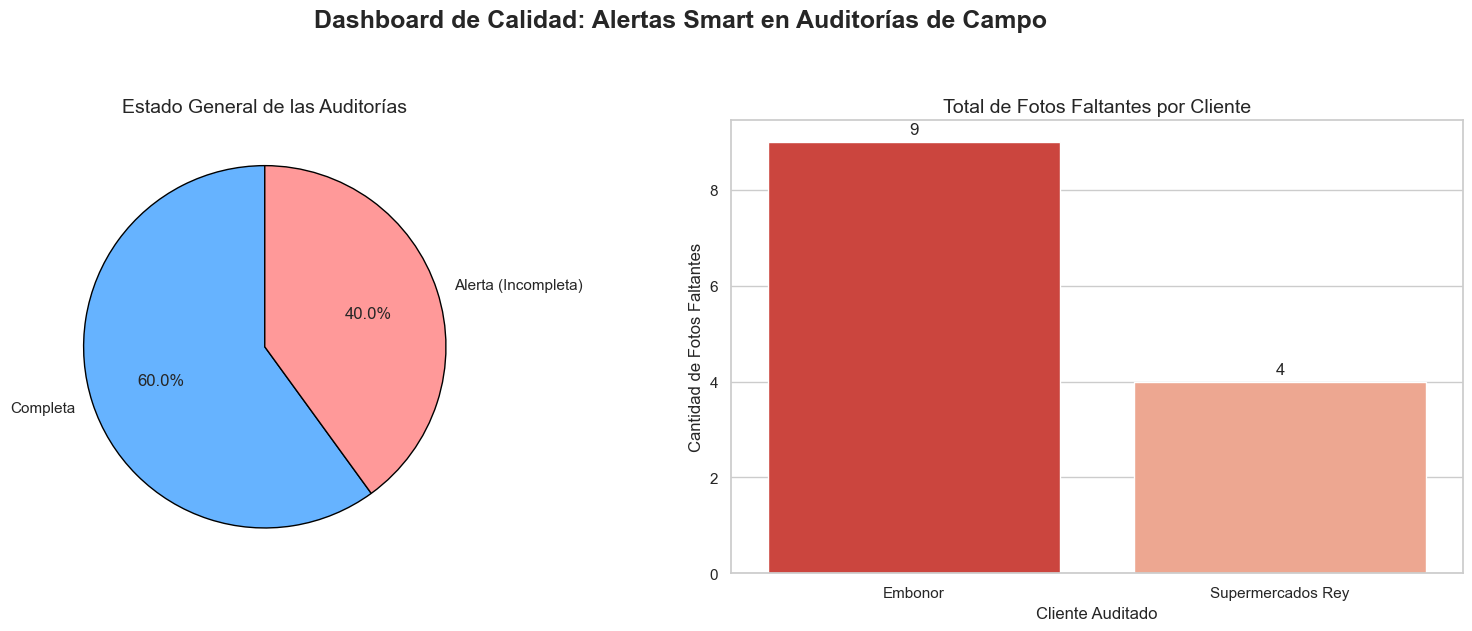

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del estilo visual
sns.set_theme(style="whitegrid")

# Preparar datos adicionales para el dashboard general
# Clasificación de todas las auditorías como 'Alerta' o 'Completas'
validacion_df['Estado'] = validacion_df['fotos_faltantes'].apply(lambda x: 'Alerta (Incompleta)' if x > 0 else 'Completa')

# Crear la figura del dashboard
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Dashboard de Calidad: Alertas Smart en Auditorías de Campo', fontsize=18, fontweight='bold', y=1.05)

# --- Gráfico 1: Proporción de Auditorías con Alertas vs Completas ---
estado_counts = validacion_df['Estado'].value_counts()
colores = ['#ff9999' if estado == 'Alerta (Incompleta)' else '#66b3ff' for estado in estado_counts.index]

axes[0].pie(estado_counts, labels=estado_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colores, wedgeprops={'edgecolor': 'black'})
axes[0].set_title('Estado General de las Auditorías', fontsize=14)

# --- Gráfico 2: Impacto de las Alertas por Cliente (Total de Fotos Faltantes) ---
# Agrupa las alertas por cliente
alertas_por_cliente = tabla_alertas_final.groupby('nombre_cliente')['fotos_faltantes'].sum().reset_index()
alertas_por_cliente = alertas_por_cliente.sort_values('fotos_faltantes', ascending=False)

if not alertas_por_cliente.empty:
    sns.barplot(data=alertas_por_cliente, x='nombre_cliente', y='fotos_faltantes', 
                ax=axes[1], palette='Reds_r')
    axes[1].set_title('Total de Fotos Faltantes por Cliente', fontsize=14)
    axes[1].set_xlabel('Cliente Auditado', fontsize=12)
    axes[1].set_ylabel('Cantidad de Fotos Faltantes', fontsize=12)
    
    # Agregar las etiquetas de datos sobre las barras
    for p in axes[1].patches:
        axes[1].annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
else:
    axes[1].text(0.5, 0.5, 'No hay alertas registradas', horizontalalignment='center', verticalalignment='center', fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()